# Final Capstone Group 2
- Peter Ogunrinde
- Kay Michnicki

## Imports & Settings

In [2]:
## unzipped the upload dataset folder
!unzip /content/FDA-Drugs-AdverseEvents.zip

Archive:  /content/FDA-Drugs-AdverseEvents.zip
   creating: FDA-Drugs-AdverseEvents/
   creating: FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/
   creating: FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/adverse_events/
  inflating: FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/adverse_events/adverse_events.csv  
  inflating: FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/adverse_events/adverse_events.parquet  
  inflating: FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/adverse_events/biologics_adverse_events.csv  
  inflating: FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/adverse_events/biologics_adverse_events.parquet  
  inflating: FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/adverse_events/device_adverse_events.csv  
  inflating: FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/adverse_events/device_adverse_events.parquet  
  inflating: FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/adverse_events/drug_adverse_events.csv  
  inflating: FDA-Dr

In [3]:
from pathlib import Path
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 160)

# Setting my environment
DATA_ROOT = Path("./FDA-Drugs-AdverseEvents")

AE_DIR      = DATA_ROOT / "fda_adverse_events_recalls" / "adverse_events"
RECALLS_DIR = DATA_ROOT / "fda_adverse_events_recalls" / "recalls"
OUT_DIR     = DATA_ROOT / "fda_adverse_events_recalls" / "adverse_events_recalls_cleaned"
PLOT_DIR    = DATA_ROOT / "adverse_events_recalls_analysis_plots"

OUT_DIR.mkdir(parents=True, exist_ok=True)
PLOT_DIR.mkdir(parents=True, exist_ok=True)

print("Paths:\n", AE_DIR, "\n", RECALLS_DIR, "\n", OUT_DIR)

Paths:
 FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/adverse_events 
 FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/recalls 
 FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/adverse_events_recalls_cleaned


### Load data (robust, no absolute-join mistakes)

In [4]:
def safe_read_csv(p: Path):
    return pd.read_csv(p) if p.exists() else None

drug_csv      = AE_DIR / "drug_adverse_events.csv"
device_csv    = AE_DIR / "device_adverse_events.csv"
biologics_csv = AE_DIR / "biologics_adverse_events.csv"
recalls_csv   = RECALLS_DIR / "recalls.csv"

drug_df      = safe_read_csv(drug_csv)
device_df    = safe_read_csv(device_csv)
biologics_df = safe_read_csv(biologics_csv)
recalls_df   = safe_read_csv(recalls_csv)

for name, df in dict(drug=drug_df, device=device_df, biologics=biologics_df, recalls=recalls_df).items():
    print(f"{name:>9}: {0 if df is None else len(df):,} rows")

     drug: 1,000 rows
   device: 1,000 rows
biologics: 51 rows
  recalls: 2,000 rows


### Shared helpers

In [5]:
def parse_ymd_int(series: pd.Series, colname="date"):
    """
    Parse integer YYYYMMDD safely (fixes earlier 1970 epoch bug).
    """
    # Keep only 8-digit yyyymmdd-like values
    s = pd.to_numeric(series, errors="coerce").astype("Int64")
    return pd.to_datetime(s.astype("string"), format="%Y%m%d", errors="coerce")

def clean_sex_to_MF(series: pd.Series):
    """
    Map 1/2 types and text to M/F; 0/unknown -> NaN.
    """
    s = series.astype(str).str.strip().str.upper()
    s = s.replace({"1": "M", "1.0": "M", "M": "M", "MALE": "M",
                   "2": "F", "2.0": "F", "F": "F", "FEMALE": "F",
                   "0": np.nan, "0.0": np.nan, "": np.nan, "NAN": np.nan, "NONE": np.nan})
    return s

def split_reactions(series: pd.Series):
    all_rx = []
    for val in series.fillna(""):
        items = [x.strip() for x in str(val).split(",") if x.strip()]
        all_rx.extend(items)
    return Counter(all_rx)

def title_or_nan(series: pd.Series):
    # Keep pure NaNs as NaN (avoid "Nan" string)
    s = series.astype("string")
    s = s.mask(s.str.strip().isin([None, "", "NAN", "NaN", "nan"]), other=np.nan)
    return s.dropna().str.title().reindex(series.index, fill_value=np.nan)

### Clean: DRUG adverse events

In [6]:
drug_clean = None
if drug_df is not None and len(drug_df):
    dc = drug_df.copy()

    # Dates (fixes 1970 bug)
    dc["receivedate_parsed"] = parse_ymd_int(dc["receivedate"])
    dc["year"] = dc["receivedate_parsed"].dt.year

    # Names & reactions
    dc["drug_product_name_cleaned"] = title_or_nan(dc["drug_product_name"])
    dc["drug_generic_name_cleaned"] = title_or_nan(dc.get("drug_generic_name", pd.Series(index=dc.index)))

    ar = dc["adverse_reactions"].astype(str).str.replace(",", ", ", regex=False)
    ar = ar.str.replace(r"\s+", " ", regex=True).str.strip().replace({"": np.nan, "nan": np.nan})
    dc["adverse_reactions_cleaned"] = ar

    # Serious (compare to INT! fixes 0% rate)
    # In FAERS extracts, serious often 1=serious, 2=non-serious
    dc["serious_binary"] = (pd.to_numeric(dc["serious"], errors="coerce") == 1).astype("Int64")

    # Demographics
    dc["patient_age_numeric"] = pd.to_numeric(dc.get("patient_age", np.nan), errors="coerce").clip(0, 120)
    dc["patient_sex_clean"] = clean_sex_to_MF(dc.get("patient_sex", np.nan))

    # Dedupe
    subset_cols = [c for c in ["safetyreportid"] if c in dc.columns]
    if subset_cols:
        dc = dc.drop_duplicates(subset=subset_cols, keep="first")

    # Quality flags
    dc["has_drug_name"] = dc["drug_product_name_cleaned"].notna()
    dc["has_reaction"]  = dc["adverse_reactions_cleaned"].notna()
    dc["has_date"]      = dc["receivedate_parsed"].notna()
    dc["quality_score"] = (dc["has_drug_name"].astype(int) + dc["has_reaction"].astype(int) + dc["has_date"].astype(int)) / 3

    drug_clean = dc
    print("Drug cleaned:", drug_clean.shape)
else:
    print("No drug data")

Drug cleaned: (1000, 29)


#### Clean: DEVICE adverse events

In [7]:
device_clean = None
if device_df is not None and len(device_df):
    dd = device_df.copy()

    # Parse report date
    dd["report_date_parsed"] = parse_ymd_int(dd["report_date"])
    dd["report_year"] = dd["report_date_parsed"].dt.year

    # Keep missing device_name as NaN (avoid "Nan" string)
    dd["device_name_cleaned"] = title_or_nan(dd.get("device_name", pd.Series(index=dd.index)))

    # to salvage a device name from raw_data JSON (best-effort)
    def try_extract_name(row):
        raw = row.get("raw_data", None)
        if pd.isna(raw): return np.nan
        try:
            obj = json.loads(raw)
            # heuristic keys frequently seen in MAUDE-like payloads
            for k in ["device_name", "devicebrandname", "brand_name", "generic_name"]:
                if k in obj and str(obj[k]).strip():
                    return str(obj[k]).strip().title()
        except Exception:
            return np.nan
        return np.nan

    # Only fill missing
    if "raw_data" in dd.columns:
        fill = dd.apply(lambda r: try_extract_name(r) if pd.isna(r["device_name_cleaned"]) else r["device_name_cleaned"], axis=1)
        dd["device_name_cleaned"] = fill

    # Normalize flags
    for col in ["event_type", "adverse_event_flag", "product_problem_flag"]:
        if col in dd.columns:
            dd[col] = dd[col].astype("string").str.strip()

    # NOTE: Do not dedup on safetyreportid (not present here)
    device_clean = dd
    print("Device cleaned:", device_clean.shape)
else:
    print("No device data")

Device cleaned: (1000, 14)


#### Clean: BIOLOGICS adverse events

In [8]:
biologics_clean = None
if biologics_df is not None and len(biologics_df):
    bc = biologics_df.copy()

    bc["receivedate_parsed"] = parse_ymd_int(bc["receivedate"])
    bc["year"] = bc["receivedate_parsed"].dt.year

    bc["biologics_product_name_cleaned"] = title_or_nan(bc["biologics_product_name"])
    bc["biologics_brand_name_cleaned"]   = title_or_nan(bc.get("biologics_brand_name", pd.Series(index=bc.index)))

    ar = bc["adverse_reactions"].astype(str).str.replace(",", ", ", regex=False)
    ar = ar.str.replace(r"\s+", " ", regex=True).str.strip().replace({"": np.nan, "nan": np.nan})
    bc["adverse_reactions_cleaned"] = ar

    bc["serious_binary"] = (pd.to_numeric(bc["serious"], errors="coerce") == 1).astype("Int64")
    bc["patient_age_numeric"] = pd.to_numeric(bc.get("patient_age", np.nan), errors="coerce").clip(0, 120)
    bc["patient_sex_clean"] = clean_sex_to_MF(bc.get("patient_sex", np.nan))

    # Dedupe if safetyreportid exists
    if "safetyreportid" in bc.columns:
        bc = bc.drop_duplicates(subset=["safetyreportid"], keep="first")

    # Quality flags
    bc["has_product_name"] = bc["biologics_product_name_cleaned"].notna()
    bc["has_reaction"]     = bc["adverse_reactions_cleaned"].notna()
    bc["has_date"]         = bc["receivedate_parsed"].notna()
    bc["quality_score"]    = (bc["has_product_name"].astype(int) + bc["has_reaction"].astype(int) + bc["has_date"].astype(int)) / 3

    biologics_clean = bc
    print("Biologics cleaned:", biologics_clean.shape)
else:
    print("No biologics data")

Biologics cleaned: (51, 26)


#### Clean: RECALLS

In [9]:
recalls_clean = None
if recalls_df is not None and len(recalls_df):
    rc = recalls_df.copy()

    # Normalize product / reason fields
    for c in [c for c in rc.columns if "product" in c.lower() or "name" in c.lower()]:
        rc[c] = rc[c].astype("string").str.strip().replace({"": np.nan})

    if "reason_for_recall" in rc.columns:
        rc["reason_for_recall"] = rc["reason_for_recall"].astype("string").str.strip().replace({"": np.nan, "nan": np.nan})

    # Dates
    rc["recall_initiation_date_parsed"] = parse_ymd_int(rc["recall_initiation_date"])
    rc["year"]  = rc["recall_initiation_date_parsed"].dt.year
    rc["month"] = rc["recall_initiation_date_parsed"].dt.month

    # Dedupe by recall_number if present
    if "recall_number" in rc.columns:
        rc = rc.drop_duplicates(subset=["recall_number"], keep="first")

    # Quality score
    has_prod = pd.Series(False, index=rc.index)
    for c in [c for c in rc.columns if "product" in c.lower() or "name" in c.lower()]:
        has_prod |= rc[c].notna()

    rc["has_reason"] = rc["reason_for_recall"].notna() if "reason_for_recall" in rc.columns else False
    rc["has_product"] = has_prod
    rc["has_date"] = rc["recall_initiation_date_parsed"].notna()
    rc["quality_score"] = (rc["has_reason"].astype(int) + rc["has_product"].astype(int) + rc["has_date"].astype(int)) / 3

    recalls_clean = rc
    print("Recalls cleaned:", recalls_clean.shape)
else:
    print("No recalls data")

Recalls cleaned: (2000, 15)


#### Quick sanity checks that fix prior misreads

In [11]:
if drug_clean is not None:
    serious_rate = (drug_clean["serious_binary"] == 1).mean() * 100
    print(f"Drug serious rate (1=serious): {serious_rate:.2f}%")  # should no longer be 0%

    print("Drug year span:", drug_clean["receivedate_parsed"].min(), "-->", drug_clean["receivedate_parsed"].max())

if device_clean is not None:
    print("Device unique names (non-null):", device_clean["device_name_cleaned"].dropna().nunique())

if recalls_clean is not None:
    print("Recalls year span:", recalls_clean["recall_initiation_date_parsed"].min(), "-->", recalls_clean["recall_initiation_date_parsed"].max())

Drug serious rate (1=serious): 45.40%
Drug year span: 2008-07-07 00:00:00 --> 2014-03-12 00:00:00
Device unique names (non-null): 0
Recalls year span: 2005-12-27 00:00:00 --> 2025-09-19 00:00:00


#### Minimal plots (safe + readable)

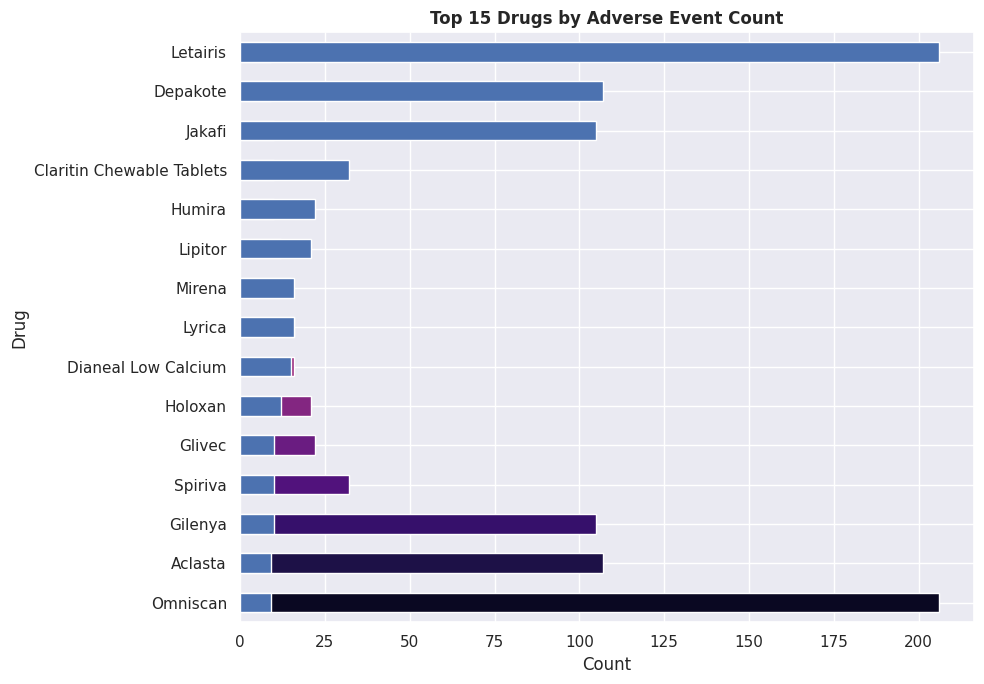

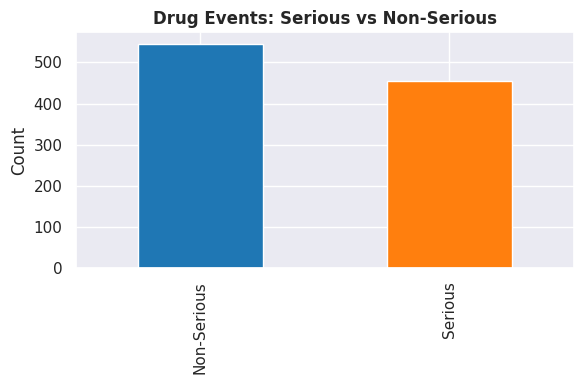

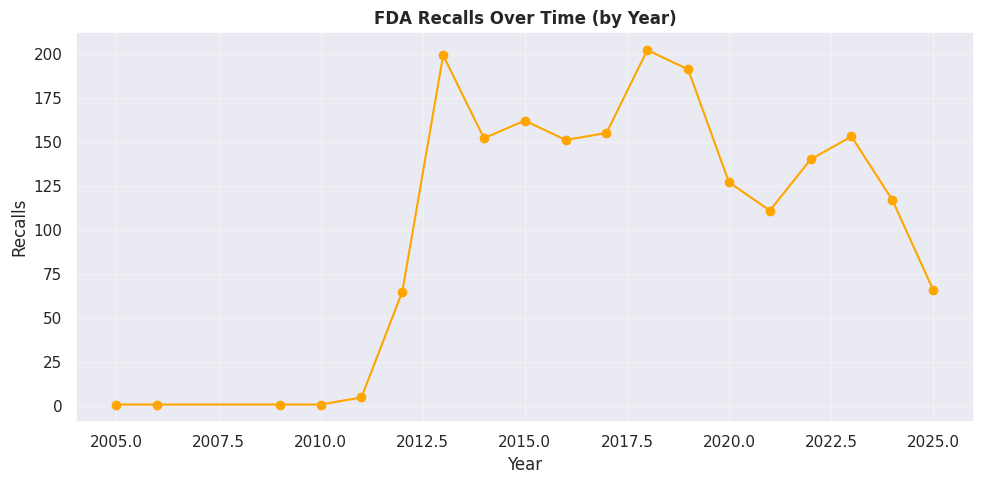

In [12]:
sns.set_theme()

if drug_clean is not None and drug_clean["drug_product_name_cleaned"].notna().any():
    top = drug_clean["drug_product_name_cleaned"].value_counts().head(15)
    top.plot(kind='barh', color=sns.color_palette('magma', len(top)))
    ax = top.sort_values().plot(kind="barh", figsize=(10,7))
    ax.set_title("Top 15 Drugs by Adverse Event Count", fontsize=12, fontweight='bold'); ax.set_xlabel("Count"); ax.set_ylabel("Drug")
    plt.tight_layout(); plt.show()

if drug_clean is not None and "serious_binary" in drug_clean.columns:
    ser_counts = drug_clean["serious_binary"].value_counts(dropna=False).rename({0:"Non-Serious",1:"Serious", pd.NA:"Unknown"})
    ax = ser_counts.plot(kind="bar", color=sns.color_palette('tab10', len(ser_counts)), figsize=(6,4))
    ax.set_title("Drug Events: Serious vs Non-Serious", fontsize=12, fontweight='bold'); ax.set_xlabel(""); ax.set_ylabel("Count")
    plt.tight_layout(); plt.show()

if recalls_clean is not None and "year" in recalls_clean.columns:
    yearly = recalls_clean["year"].value_counts().sort_index()
    ax = yearly.plot(kind="line", marker="o", figsize=(10,5) , color='orange')
    ax.set_title("FDA Recalls Over Time (by Year)",fontsize=12, fontweight='bold'); ax.set_xlabel("Year"); ax.set_ylabel("Recalls")
    plt.grid(alpha=.3); plt.tight_layout(); plt.show()

### Save cleaned datasets

In [13]:
def save(df: pd.DataFrame, name: str):
    if df is None: return
    df.to_parquet(OUT_DIR / f"{name}.parquet", index=False)
    df.to_csv(OUT_DIR / f"{name}.csv", index=False)
    print("Saved:", name)

save(drug_clean, "drug_adverse_events_cleaned")
save(device_clean, "device_adverse_events_cleaned")
save(biologics_clean, "biologics_adverse_events_cleaned")
save(recalls_clean, "recalls_cleaned")

Saved: drug_adverse_events_cleaned
Saved: device_adverse_events_cleaned
Saved: biologics_adverse_events_cleaned
Saved: recalls_cleaned


## EDA (brief results)

- **Rows** - drug: **1,000**, device: **1,000**, biologics: **51**, recalls: **2,000**.

- Fixes applied - correct YYYYMMDD parsing; serious_binary cast from int (fixes prior 0% issue); text cleaned; device names preserved as true NaN (no "Nan"); quality flags; deduping where keys exist.


***Spans / sanity***

- Drug dates: 2008-07-07 --> 2014-03-12
- Recalls dates: 2005-12-27 --> 2025-09-19
- Drug serious rate: **45.40%**
- Device unique names (non-null): 0 (source limitation)

**Saved to** .../adverse_events_recalls_cleaned/*.parquet and *.csv.

---

# Model Design/Building

### Imports & Global Config

In [14]:
# MODEL DESIGN / BUILDING — BASELINES (SKLEARN)

# Goals:
# A) DRUG_SERIOUS: Predict serious (1) vs non-serious (0)
# B) RECALL_CLASS: Predict recall class (I/II/III)

# Design choices:
# - Regularized linear baselines (LogReg, LinearSVC) with TF-IDF
# - Robust preprocessing: text + small tabular features
# - Stratified splits, 5-fold CV grid search
# - Save best pipelines for reuse

#Imports, paths, helpers
from pathlib import Path
import re, json, itertools
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.impute import SimpleImputer
import joblib

RANDOM_STATE = 42
pd.set_option("display.max_colwidth", 120)

# Match the EDA layout
DATA_ROOT = Path("./FDA-Drugs-AdverseEvents")
CLEAN_DIR = DATA_ROOT / "fda_adverse_events_recalls" / "adverse_events_recalls_cleaned"
MODEL_DIR = DATA_ROOT / "fda_adverse_events_recalls" / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print("Clean dir:", CLEAN_DIR.resolve())
print("Model dir:", MODEL_DIR.resolve())

def load_clean(name: str):
    pq = CLEAN_DIR / f"{name}.parquet"
    cs = CLEAN_DIR / f"{name}.csv"
    if pq.exists():
        df = pd.read_parquet(pq); print(f"Loaded {name} (parquet):", df.shape); return df
    if cs.exists():
        df = pd.read_csv(cs);     print(f"Loaded {name} (csv):", df.shape);     return df
    print(f"[WARN] Missing cleaned file: {name}")
    return None

def clean_text(s: pd.Series) -> pd.Series:
    s = s.astype("string").fillna("")
    return s.str.replace(r"\s+", " ", regex=True).str.strip()

def show_class_balance(y, title="Class balance"):
    vc = pd.Series(y).value_counts(dropna=False).sort_index()
    print(f"\n{title}:\n{vc.to_string()}")
    if len(vc) and vc.min() < 20:
        print("NOTE: at least one class has <20 samples; metrics may be noisy.")

Clean dir: /content/FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/adverse_events_recalls_cleaned
Model dir: /content/FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/models


In [16]:
# Load cleaned datasets (from the EDA step)
#drug = load_clean("drug_adverse_events_cleaned")
#reca = load_clean("recalls_cleaned")

### Helper loaders & utilities

In [17]:
# Load cleaned datasets (created in EDA step)
# Fallback: if parquet not available, try csv.
def load_clean(name: str):
    pq = CLEAN_DIR / f"{name}.parquet"
    cs = CLEAN_DIR / f"{name}.csv"
    if pq.exists():
        df = pd.read_parquet(pq); print(f"Loaded {name} (parquet):", df.shape);
        return df
    if cs.exists():
        df = pd.read_csv(cs);     print(f"Loaded {name} (csv):", df.shape);
        return df
    print(f"[WARN] Missing cleaned file: {name}")
    return None

def clean_text(s: pd.Series) -> pd.Series:
    s = s.astype("string").fillna("")
    return s.str.replace(r"\s+", " ", regex=True).str.strip()

def show_class_balance(y, title="Class balance"):
    vc = pd.Series(y).value_counts(dropna=False).sort_index()
    print(f"\n{title}:\n{vc.to_string()}")
    if len(vc) and vc.min() < 20:
        print("NOTE: One or more classes are small; metrics may be noisy.")

drug = load_clean("drug_adverse_events_cleaned")
reca = load_clean("recalls_cleaned")

Loaded drug_adverse_events_cleaned (parquet): (1000, 29)
Loaded recalls_cleaned (parquet): (2000, 15)



**Drug Adverse Events: Predict** serious_binary

**Goal**: To build a baseline classifier that uses text + simple tabular features.

**Features:**
- **Text**: adverse_reactions_cleaned + drug names (concatenated)
- **Numeric**: patient_age_numeric
- **Categorical**: patient_sex_clean (M/F)
- **Target**: serious_binary (drop NaNs)

### Build training frame for DRUG model: Drug Adverse Events - predict serious_binary

In [18]:
# Task A: DRUG_SERIOUS baseline
if drug is not None and len(drug):
    df = drug.copy()
    df = df[df["serious_binary"].notna()].copy()
    df["serious_binary"] = df["serious_binary"].astype(int)

    # Text: reactions + product names
    for col in ["adverse_reactions_cleaned","drug_product_name_cleaned","drug_generic_name_cleaned"]:
        if col not in df.columns: df[col] = ""
    df["txt"] = clean_text(
        df["adverse_reactions_cleaned"].fillna("") + " " +
        df["drug_product_name_cleaned"].fillna("") + " " +
        df["drug_generic_name_cleaned"].fillna("")
    )

    # Tabular: age & sex
    if "patient_age_numeric" not in df.columns: df["patient_age_numeric"] = np.nan
    df["patient_age_numeric"] = pd.to_numeric(df["patient_age_numeric"], errors="coerce").clip(0, 120)
    if "patient_sex_clean" not in df.columns: df["patient_sex_clean"] = np.nan

    X = df[["txt","patient_age_numeric","patient_sex_clean"]].copy()
    y = df["serious_binary"].copy()

    print("DRUG frame:", X.shape, "target:", y.shape)
    show_class_balance(y, "DRUG: Serious (1) vs Non-Serious (0)")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
    )
    print("Train/Test:", X_train.shape, X_test.shape)

    # Preprocess + Logistic Regression
    preproc = ColumnTransformer(
        transformers=[
            ("txt", TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=3, max_df=0.95, sublinear_tf=True), "txt"),
            ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                              ("sc", StandardScaler(with_mean=False))]), ["patient_age_numeric"]),
            ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                              ("oh",  OneHotEncoder(handle_unknown="ignore"))]), ["patient_sex_clean"]),
        ],
        remainder="drop",
        verbose_feature_names_out=False
    )

    pipe_lr = Pipeline([
        ("prep", preproc),
        ("clf", LogisticRegression(max_iter=200, class_weight="balanced",
                                   solver="liblinear", random_state=RANDOM_STATE))
    ])

    grid_lr = GridSearchCV(
        pipe_lr,
        param_grid={"clf__C":[0.25,0.5,1.0,2.0], "clf__penalty":["l1","l2"]},
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
        n_jobs=-1, scoring="f1"
    )
    grid_lr.fit(X_train, y_train)

    print("Best LR params:", grid_lr.best_params_)
    print("CV best F1:", grid_lr.best_score_)
    y_pred = grid_lr.predict(X_test)
    if hasattr(grid_lr.best_estimator_["clf"], "predict_proba"):
        y_proba = grid_lr.predict_proba(X_test)[:,1]
        print("Test ROC-AUC:", round(roc_auc_score(y_test, y_proba), 4))
    print("\nClassification Report (LR):\n", classification_report(y_test, y_pred, digits=3))
    print("Confusion Matrix (LR):\n", confusion_matrix(y_test, y_pred))

    # Save LR pipeline
    joblib.dump(grid_lr.best_estimator_, MODEL_DIR / "drug_serious_lr.joblib")
    print("Saved ->", (MODEL_DIR / "drug_serious_lr.joblib").name)

    # Alternative: Linear SVM
    pipe_svm = Pipeline([
        ("prep", preproc),
        ("clf", LinearSVC(class_weight="balanced", random_state=RANDOM_STATE))
    ])
    grid_svm = GridSearchCV(pipe_svm, param_grid={"clf__C":[0.5,1.0,2.0]},
                            cv=5, n_jobs=-1, scoring="f1")
    grid_svm.fit(X_train, y_train)
    print("\nBest SVM params:", grid_svm.best_params_)
    print("CV best F1 (SVM):", grid_svm.best_score_)
    y_pred_svm = grid_svm.predict(X_test)
    print("\nClassification Report (SVM):\n", classification_report(y_test, y_pred_svm, digits=3))
    print("Confusion Matrix (SVM):\n", confusion_matrix(y_test, y_pred_svm))

    joblib.dump(grid_svm.best_estimator_, MODEL_DIR / "drug_serious_svm.joblib")
    print("Saved ->", (MODEL_DIR / "drug_serious_svm.joblib").name)
else:
    print("[SKIP] No drug data.")

DRUG frame: (1000, 3) target: (1000,)

DRUG: Serious (1) vs Non-Serious (0):
serious_binary
0    546
1    454
Train/Test: (800, 3) (200, 3)
Best LR params: {'clf__C': 2.0, 'clf__penalty': 'l1'}
CV best F1: 0.8544871638886622
Test ROC-AUC: 0.9486

Classification Report (LR):
               precision    recall  f1-score   support

           0      0.881     0.881     0.881       109
           1      0.857     0.857     0.857        91

    accuracy                          0.870       200
   macro avg      0.869     0.869     0.869       200
weighted avg      0.870     0.870     0.870       200

Confusion Matrix (LR):
 [[96 13]
 [13 78]]
Saved -> drug_serious_lr.joblib

Best SVM params: {'clf__C': 0.5}
CV best F1 (SVM): 0.8420136153065177

Classification Report (SVM):
               precision    recall  f1-score   support

           0      0.887     0.936     0.911       109
           1      0.918     0.857     0.886        91

    accuracy                          0.900       200
  

### Recalls: extract class from raw_data --> train classifier
- Extract classification from nested JSON then map to {1,2,3}

In [19]:
# RECALL_CLASS - label extraction
if reca is not None and len(reca):
    df_r = reca.copy()

    # Normalize headers (strip + lowercase) to make lookups robust
    norm = {c: re.sub(r"\s+", " ", c).strip().lower() for c in df_r.columns}
    df_r.rename(columns=norm, inplace=True)
    print("\n[Recalls] Columns:", list(df_r.columns))

    # pull 'classification' from raw_data JSON
    def find_classification(obj):
        """Recursively find likely class keys in nested dict/list."""
        KEYS = {"classification", "recall_class", "class",
                "recall_classification", "classification_type"}
        if isinstance(obj, dict):
            for k, v in obj.items():
                kl = re.sub(r"\s+", " ", str(k)).strip().lower().replace(" ", "_")
                if kl in KEYS:
                    return str(v)
            # search deeper
            for v in obj.values():
                got = find_classification(v)
                if got is not None: return got
        elif isinstance(obj, list):
            for it in obj:
                got = find_classification(it)
                if got is not None: return got
        return None

    def extract_class_from_raw(txt):
        if pd.isna(txt): return np.nan
        try:
            obj = json.loads(txt)
        except Exception:
            return np.nan
        return find_classification(obj)

    if "raw_data" in df_r.columns:
        df_r["class_from_raw"] = df_r["raw_data"].apply(extract_class_from_raw)
    else:
        df_r["class_from_raw"] = np.nan

    print("\n[class_from_raw] examples:")
    display(df_r.loc[df_r["class_from_raw"].notna(), ["class_from_raw"]].head(10))
    print("Non-null count:", int(df_r["class_from_raw"].notna().sum()), "/", len(df_r))

    # map 'Class I/II/III' --> {1,2,3}; with fallback from reason text
    def map_class_label(v):
        if pd.isna(v): return np.nan
        s = str(v).upper().strip()
        if re.search(r"\bCLASS\s*I\b|\bCLASS\s*1\b|^I$", s):   return 1
        if re.search(r"\bCLASS\s*II\b|\bCLASS\s*2\b|^II$", s): return 2
        if re.search(r"\bCLASS\s*III\b|\bCLASS\s*3\b|^III$", s): return 3
        return np.nan

    df_r["recall_class_num"] = df_r["class_from_raw"].map(map_class_label)

    # Fallback: sometimes reason text has the class string too
    if "reason_for_recall" in df_r.columns:
        def infer_from_reason(txt):
            if pd.isna(txt): return np.nan
            s = str(txt).upper()
            if "CLASS I"   in s: return 1
            if "CLASS II"  in s: return 2
            if "CLASS III" in s: return 3
            return np.nan
        df_r["recall_class_num"] = df_r["recall_class_num"].fillna(
            df_r["reason_for_recall"].apply(infer_from_reason)
        )

    print("\nClass counts (after JSON + fallback):")
    print(df_r["recall_class_num"].value_counts(dropna=False).sort_index())

else:
    df_r = None
    print("[SKIP] No recalls data.")


[Recalls] Columns: ['recall_number', 'recall_initiation_date', 'product_description', 'reason_for_recall', 'product_type', 'recalling_firm', 'status', 'raw_data', 'recall_initiation_date_parsed', 'year', 'month', 'has_reason', 'has_product', 'has_date', 'quality_score']

[class_from_raw] examples:


,class_from_raw
0,Class II
1,Class II
2,Class II
3,Class II
4,Class II
5,Class III
6,Class II
7,Class II
8,Class II
9,Class II


Non-null count: 2000 / 2000

Class counts (after JSON + fallback):
recall_class_num
1     211
2    1675
3     114
Name: count, dtype: int64


#### Train Recalls classifier (robust TF-IDF with fallback)

In [20]:
# RECALL_CLASS - model training
if df_r is not None:
    present = sorted([int(x) for x in df_r["recall_class_num"].dropna().unique()]) \
              if df_r["recall_class_num"].notna().any() else []
    print("\nPresent classes:", present)

    if len(present) >= 2 and "reason_for_recall" in df_r.columns:
        Xr = df_r.loc[df_r["recall_class_num"].notna(), ["reason_for_recall"]].copy()
        yr = df_r.loc[df_r["recall_class_num"].notna(), "recall_class_num"].astype(int).copy()

        # Clean text lightly; avoid empty strings
        Xr["reason_for_recall"] = clean_text(Xr["reason_for_recall"])
        empty_n = int((Xr["reason_for_recall"].str.len() == 0).sum())
        if empty_n:
            print(f"[INFO] Dropping {empty_n} empty reason texts.")
            keep = Xr["reason_for_recall"].str.len() > 0
            Xr, yr = Xr.loc[keep], yr.loc[keep]

        Xr_train, Xr_test, yr_train, yr_test = train_test_split(
            Xr, yr, test_size=0.20, random_state=RANDOM_STATE, stratify=yr
        )
        print("Recalls Train/Test:", Xr_train.shape, Xr_test.shape)

        # Safe TF-IDF block: retry with min_df=1 if CV hits empty-vocabulary
        def build_pipe(min_df=3):
            pre_r = ColumnTransformer(
                transformers=[("txt", TfidfVectorizer(lowercase=True, ngram_range=(1,2),
                                                      min_df=min_df, max_df=0.95, sublinear_tf=True),
                               "reason_for_recall")],
                remainder="drop"
            )
            pipe_r = Pipeline([
                ("prep", pre_r),
                ("clf", LogisticRegression(max_iter=300, multi_class="ovr",
                                           class_weight="balanced", solver="liblinear",
                                           random_state=RANDOM_STATE))
            ])
            return pipe_r

        # First try with min_df=3 ( setting)
        pipe_r = build_pipe(min_df=3)
        grid_r = GridSearchCV(pipe_r, param_grid={"clf__C":[0.5,1.0,2.0]},
                              cv=5, n_jobs=-1, scoring="f1_macro")

        try:
            grid_r.fit(Xr_train, yr_train)
        except ValueError as e:
            # Commonly triggered by "empty vocabulary" on some CV folds
            if "empty vocabulary" in str(e).lower():
                print("[WARN] Empty vocabulary on some folds; retrying with min_df=1.")
                pipe_r = build_pipe(min_df=1)
                grid_r = GridSearchCV(pipe_r, param_grid={"clf__C":[0.5,1.0,2.0]},
                                      cv=5, n_jobs=-1, scoring="f1_macro")
                grid_r.fit(Xr_train, yr_train)
            else:
                raise

        print("Best Recalls LR params:", grid_r.best_params_)
        print("CV best F1_macro:", grid_r.best_score_)
        yr_pred = grid_r.predict(Xr_test)
        print("\nClassification Report (Recalls):\n", classification_report(yr_test, yr_pred, digits=3))
        print("Confusion Matrix (Recalls):\n", confusion_matrix(yr_test, yr_pred))

        # Save model
        joblib.dump(grid_r.best_estimator_, MODEL_DIR / "recalls_class_lr.joblib")
        print("Saved -->", (MODEL_DIR / "recalls_class_lr.joblib").name)
    else:
        print("[INFO] Recalls model not trained — missing labels or only one class available.")


Present classes: [1, 2, 3]
[INFO] Dropping 2 empty reason texts.
Recalls Train/Test: (1598, 1) (400, 1)
Best Recalls LR params: {'clf__C': 2.0}
CV best F1_macro: 0.7123095319286237

Classification Report (Recalls):
               precision    recall  f1-score   support

           1      0.806     0.595     0.685        42
           2      0.924     0.946     0.935       335
           3      0.538     0.609     0.571        23

    accuracy                          0.890       400
   macro avg      0.756     0.717     0.730       400
weighted avg      0.890     0.890     0.888       400

Confusion Matrix (Recalls):
 [[ 25  17   0]
 [  6 317  12]
 [  0   9  14]]
Saved --> recalls_class_lr.joblib


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


***Load & predict demo***

In [22]:
import joblib, pandas as pd
from pathlib import Path

MODEL_DIR = Path("./FDA-Drugs-AdverseEvents/fda_adverse_events_recalls/models")

# Drug serious prediction
drug_pipe = joblib.load(MODEL_DIR / "drug_serious_lr.joblib")
demo_drug = pd.DataFrame({
    "txt": ["rash and shortness of breath after dose", "mild headache resolved same day"],
    "patient_age_numeric": [67, 23],
    "patient_sex_clean": ["M","F"],
})
print("Drug serious proba:", drug_pipe.predict_proba(demo_drug)[:,1])

# Recall class prediction
recalls_pipe = joblib.load(MODEL_DIR / "recalls_class_lr.joblib")
demo_recalls = pd.DataFrame({"reason_for_recall": [
    "Potential contamination with microbial pathogens.",
    "Incorrect labeling: missing allergy information.",
]})
print("Recall class preds:", recalls_pipe.predict(demo_recalls).tolist())

Drug serious proba: [0.78290109 0.78272425]
Recall class preds: [1, 3]


**Fast error analysis (recalls)**

In [23]:
from sklearn.metrics import classification_report
X_test_txt = Xr_test["reason_for_recall"].tolist()
y_pred = grid_r.predict(Xr_test)
print(classification_report(yr_test, y_pred, digits=3))

# Inspect a few mistakes
errs = [(i, t, p, X_test_txt[i]) for i,(t,p) in enumerate(zip(yr_test, y_pred)) if t!=p]
for i,(idx,t,p,txt) in enumerate(errs[:10],1):
    print(f"{i:02d}. true={t} pred={p}  :: {txt[:140]}...")

              precision    recall  f1-score   support

           1      0.806     0.595     0.685        42
           2      0.924     0.946     0.935       335
           3      0.538     0.609     0.571        23

    accuracy                          0.890       400
   macro avg      0.756     0.717     0.730       400
weighted avg      0.890     0.890     0.888       400

01. true=1 pred=2  :: The device may experience mechanical interference on the Fluid Valve pins, which will trigger a Pump Problem alarm. The issue may lead to de...
02. true=2 pred=3  :: Failed Impurities/Degradation Specifications; Out of specification result obtained for impurity A during stability testing....
03. true=3 pred=2  :: Frayed pieces of the mounting card being inside the primary packaging....
04. true=1 pred=2  :: There is a risk of endobronchial combustion if high-frequency cauterization is performed while supplying oxygen [and/or] the electrode secti...
05. true=2 pred=1  :: Marketed Without An 

## Model Design/Building and Trainning Information:

**A) Drug Adverse Events** --> **predict** serious_binary

- **Features**: TF-IDF on concatenated reactions + product names; tabular age (scaled) + sex (OHE).
- **Modeling**: 80/20 stratified split; 5-fold CV; LogReg (class_weight=balanced), LinearSVC baseline.
- **Best LR**: C=2.0, penalty='l1'; ROC-AUC = 0.9486; test accuracy = 0.870; F1 (0)=0.881, F1 (1)=0.857.
- **Best SVM**: C=0.5; test **accuracy = 0.900**; **macro-F1 ~ 0.899**.

- ***Saved:*** models/drug_serious_lr.joblib, models/drug_serious_svm.joblib.

---

**B) Recalls** --> ***predict*** Class I/II/III

- **Key fix:** classification extracted from nested raw_data JSON (e.g., "classification":"Class II"), mapped to `{1,2,3}` with regex fallback on reason_for_recall.

- **Class counts:** Class I 211, Class II 1675, Class III 114 (high imbalance).

- **Features**: TF-IDF on reason_for_recall.

- **Modeling**: 80/20 stratified; 5-fold CV; LogReg (OvR), with an empty-vocabulary guard that retries TF-IDF at min_df=1 if needed.

- **Best LR:** C=2.0; CV **macro-F1 = 0.7123**; test **accuracy = 0.890.**
- *Class-wise (test, 400 rows):*
  - **Class I**: P=0.806, R=0.595, F1=0.685 (minority class)
  - **Class II:** P=0.924, R=0.946, F1=0.935
  - **Class III:** P=0.538, R=0.609, F1=0.571

**Saved**: models/recalls_class_lr.joblib.

In [25]:
# For sownloads the recent updated files.
#!tar -czvf FDA-Drugs-AdverseEvents.tar.gz /content/FDA-Drugs-AdverseEvents